In [59]:
using JUDI, PyPlot, DSP, SegyIO, JLD, SlimPlotting, HDF5, Statistics

In [60]:
block = segy_read("../data/sgy/marmousi_2D.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=407992804, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO ~/.julia/packages/SegyIO/OfiKG/src/read/read_file.jl:36


## 00_Ploting Data Shot Record

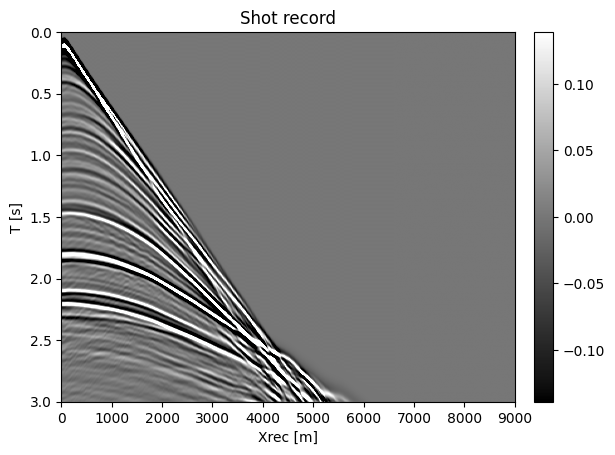

In [61]:
num_of_shot = 2
plot_sdata(d_obs.data[num_of_shot], (0.002, 25); cbar=true)

## 01_Plotting Frequency Spectrum

We define a function to extract the spectrum data, including both the magnitude of the sample and their corresponding frequencies, by implementing the FFT using DSP package.

In [62]:
function extracted_mean_spectrum(shot_gather, fs)
    n_samples, n_traces = size(shot_gather)
    mean_spectrum = zeros(n_samples)
    for i in 1:n_traces
        spectrum = abs.(fft(shot_gather[:, i]))
        mean_spectrum .+= spectrum
    end
    mean_spectrum ./= n_traces
    mean_spectrum = mean_spectrum ./ maximum(mean_spectrum)
    freqs = DSP.fftfreq(n_samples, fs)
    # Separate positive frequencies
    pos_freqs = freqs[1:div(n_samples, 2)+1]

    return pos_freqs, mean_spectrum[1:div(n_samples, 2)+1]
end

extracted_mean_spectrum (generic function with 1 method)

Ploting spectrum frequency of raw data

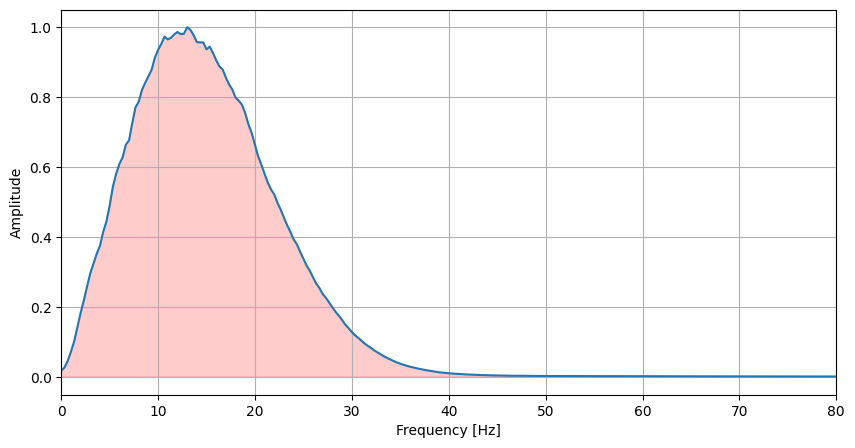

In [63]:
dt = d_obs.geometry.taxis[1].step * 1e-3  #sampling time in s
fs = 1 / dt #frequency of sample

shot_gather = d_obs.data[num_of_shot];

figure(figsize=(10, 5))
grid()
pos_freqs, mean_spectrum = extracted_mean_spectrum(shot_gather, fs)
plot(pos_freqs, mean_spectrum)
fill_between(x=pos_freqs, y1=mean_spectrum, color= "r", alpha= 0.2)
id_max_amp = argmax(mean_spectrum)
# vlines(pos_freqs[id_max_amp], ymin=0,  ymax=mean_spectrum[id_max_amp])
xlim(0, 80)
xlabel("Frequency [Hz]")
ylabel("Amplitude");

We can see that, the maximum  or dominant frequency arround 12-15 Hz, which matches the source wavelet frequency arround 15 Hz.

## 02_Split the Dataset to Low Frequency and High Frequency

In [64]:
cut_of_freq = 10 #Hz

shot_gather_lpf = filtfilt(digitalfilter(Lowpass(cut_of_freq; fs=fs), Butterworth(5)), shot_gather);
shot_gather_hpf = filtfilt(digitalfilter(Highpass(cut_of_freq; fs=fs), Butterworth(5)), shot_gather);

Plot spectrum frequency both for Low-Pass-Filter(LPF) and High-Pass-Filter(HPF)

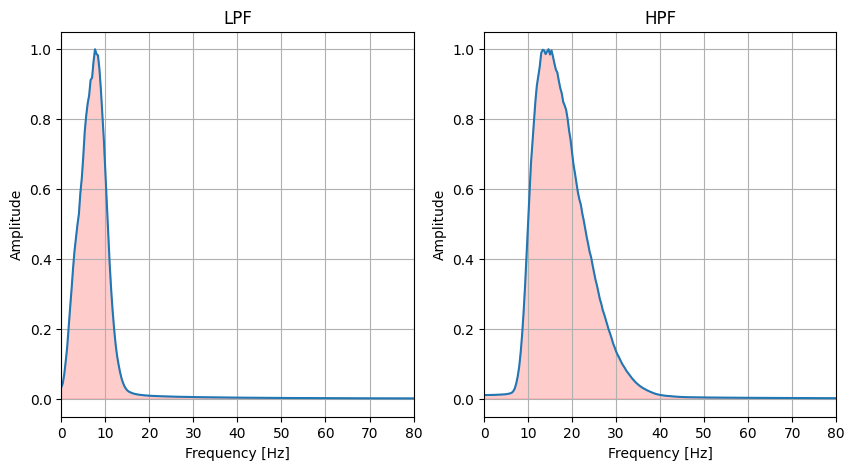

In [65]:
pos_freqs, mean_spectrum_lpf = extracted_mean_spectrum(shot_gather_lpf, fs)
pos_freqs, mean_spectrum_hpf = extracted_mean_spectrum(shot_gather_hpf, fs)

figure(figsize=(10, 5))
subplot(1, 2, 1)
grid()
plot(pos_freqs, mean_spectrum_lpf)
fill_between(x=pos_freqs, y1=mean_spectrum_lpf, color= "r", alpha= 0.2)
xlim(0, 80)
title("LPF")
xlabel("Frequency [Hz]")
ylabel("Amplitude");

subplot(1, 2, 2)
grid()
title("HPF")
plot(pos_freqs, mean_spectrum_hpf)
fill_between(x=pos_freqs, y1=mean_spectrum_hpf, color= "r", alpha= 0.2)
xlim(0, 80)
xlabel("Frequency [Hz]")
ylabel("Amplitude");

Plotting shot-record for both LPF and HPF Filter

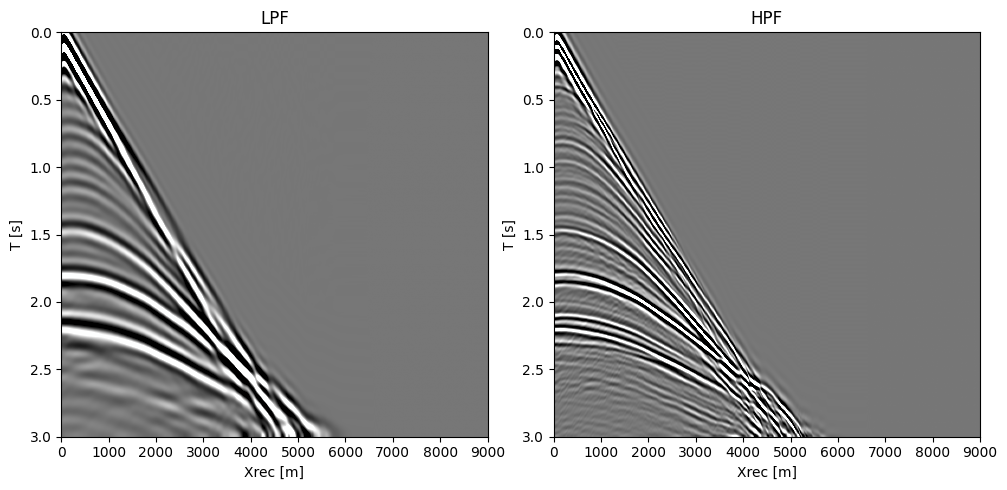

In [66]:
figure(figsize=(10, 5))
subplot(121)
plot_sdata(shot_gather_lpf, (0.002, 25);  new_fig = false, name = "LPF")
subplot(122)
plot_sdata(shot_gather_hpf, (0.002, 25);  new_fig = false, name = "HPF")
tight_layout();

## Standardization Data

11.242166
-6.7524967
56.940144
-34.200504


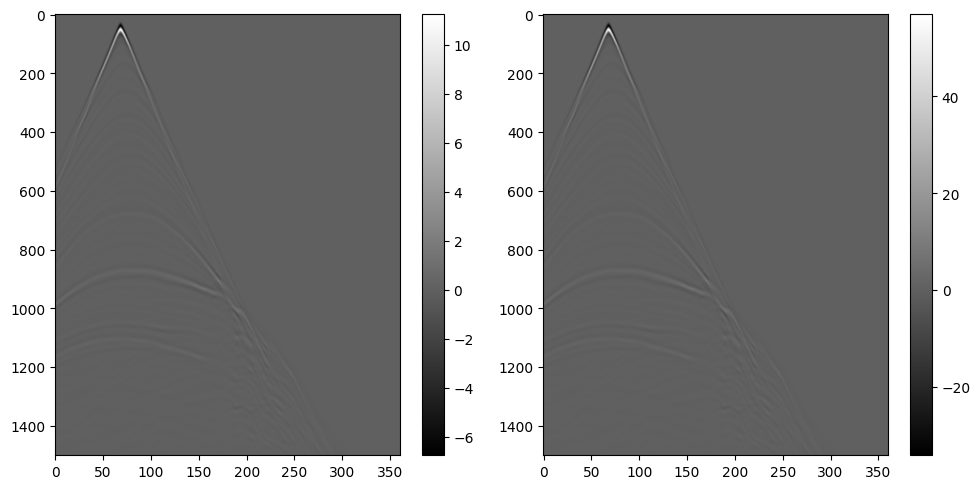

In [67]:
image = d_obs.data[num_shot]
mn = mean(image)
std_arr = std(image)
image_norm = (image .- mn) ./ std_arr;

println(maximum(image))
println(minimum(image))

println(maximum(image_norm))
println(minimum(image_norm))


figure(figsize=(10, 5))
subplot(121)
# plot_sdata(image, (0.002, 25);  new_fig = false, name = "Before Norm", cbar=true)
imshow(image, aspect="auto", cmap="gray")
colorbar()
subplot(122)
# plot_sdata(image_norm, (0.002, 25);  new_fig = false, name = "After Norm", cbar=true)
imshow(image_norm, aspect="auto", cmap="gray")
colorbar()
tight_layout();

In [68]:
raw_data_norm = []
for i in 1:size(d_obs)[1]
    image = d_obs.data[i]
    mn = mean(image)
    std_arr = std(image)
    image_norm = (image .- mn) ./ std_arr;
    push!(raw_data_norm, image_norm)
end

In [69]:
input_data_10Hz = []
label_lesslow_5Hz = []
label_lesslow_7Hz = []

for i in 1:size(d_obs)[1]
    shot_gather_hpf_10Hz = filtfilt(digitalfilter(Highpass(10; fs=fs), Butterworth(5)), d_obs.data[i]);
    shot_gather_hpf_7Hz = filtfilt(digitalfilter(Highpass(7; fs=fs), Butterworth(5)), d_obs.data[i]);
    shot_gather_hpf_5Hz = filtfilt(digitalfilter(Highpass(5; fs=fs), Butterworth(5)), d_obs.data[i]);
    
    push!(input_data_10Hz, Float32.(shot_gather_hpf_10Hz)) 
    push!(label_lesslow_7Hz, Float32.(shot_gather_hpf_7Hz))
    push!(label_lesslow_5Hz, Float32.(shot_gather_hpf_5Hz))
    
end

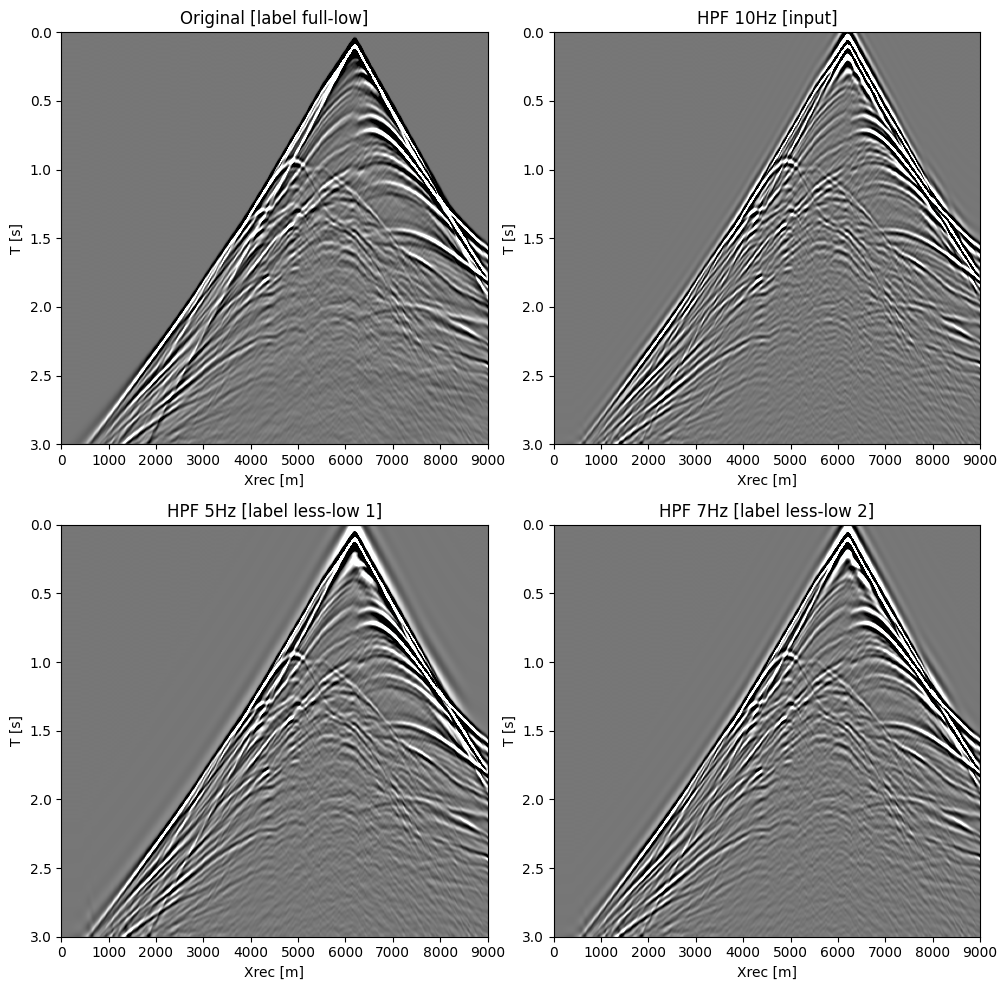

In [70]:
num_shot = 125

figure(figsize=(10, 10))
subplot(221)
plot_sdata(d_obs.data[num_shot], (0.002, 25);  new_fig = false, name = "Original [label full-low]")
subplot(222)
plot_sdata(input_data_10Hz[num_shot], (0.002, 25);  new_fig = false, name = "HPF 10Hz [input]")
subplot(223)
plot_sdata(label_lesslow_5Hz[num_shot], (0.002, 25);  new_fig = false, name = "HPF 5Hz [label less-low 1]")
subplot(224)
plot_sdata(label_lesslow_7Hz[num_shot], (0.002, 25);  new_fig = false, name = "HPF 7Hz [label less-low 2]")

tight_layout();

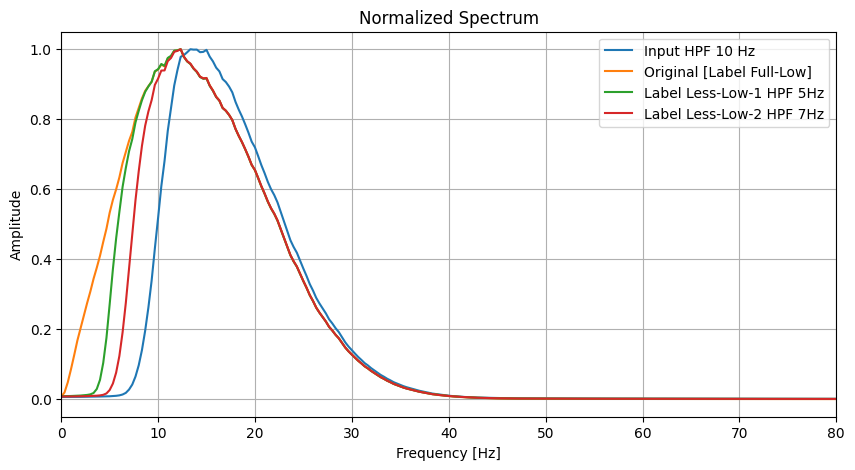

In [71]:
pos_freqs, mean_spectrum_original = extracted_mean_spectrum(d_obs.data[num_shot], fs)
_, mean_spectrum_hpf_10_Hz = extracted_mean_spectrum(input_data_10Hz[num_shot], fs)
_, mean_spectrum_hpf_7_Hz = extracted_mean_spectrum(label_lesslow_7Hz[num_shot], fs)
_, mean_spectrum_hpf_5_Hz = extracted_mean_spectrum(label_lesslow_5Hz[num_shot], fs)

figure(figsize=(10,5))
plot(pos_freqs, mean_spectrum_hpf_10_Hz, label="Input HPF 10 Hz")
plot(pos_freqs, mean_spectrum_original, label="Original [Label Full-Low]")
plot(pos_freqs, mean_spectrum_hpf_5_Hz, label="Label Less-Low-1 HPF 5Hz")
plot(pos_freqs, mean_spectrum_hpf_7_Hz, label="Label Less-Low-2 HPF 7Hz")

legend()
grid()
xlim(0, 80)
title("Normalized Spectrum")
xlabel("Frequency [Hz]")
ylabel("Amplitude");


## 03 Patching Data 

We sample data using 2D image, 128x128 pixel

In [81]:
using Random

raw_data_norm_patches = []
input_patch = []
label_full = []
label_less_low_1 = []
label_less_low_2 = []

patch_size = 128
max_row, max_col = size(d_obs.data[1])
n_patch_per_shot = 50

for i in 1:size(d_obs.data)[1]
    
    id_row = rand(1:max_row-patch_size, n_patch_per_shot)
    id_col = rand(1:max_col-patch_size, n_patch_per_shot)
    
    for j in 1:n_patch_per_shot
        id_start_row = id_row[j]
        id_end_row = id_start_row + patch_size - 1
        
        id_start_col = id_col[j]
        id_end_col = id_start_col + patch_size - 1

        push!(input_patch, input_data_10Hz[num_shot][id_start_row:id_end_row,id_start_col:id_end_col])
        push!(label_full, d_obs.data[num_shot][id_start_row:id_end_row,id_start_col:id_end_col])
        push!(label_less_low_1, label_lesslow_5Hz[num_shot][id_start_row:id_end_row,id_start_col:id_end_col])
        push!(label_less_low_2, label_lesslow_7Hz[num_shot][id_start_row:id_end_row,id_start_col:id_end_col])
        push!(raw_data_norm_patches, raw_data_norm[num_shot][id_start_row:id_end_row,id_start_col:id_end_col])
    end
end

(9050,)
(9050,)
(9050,)
(9050,)


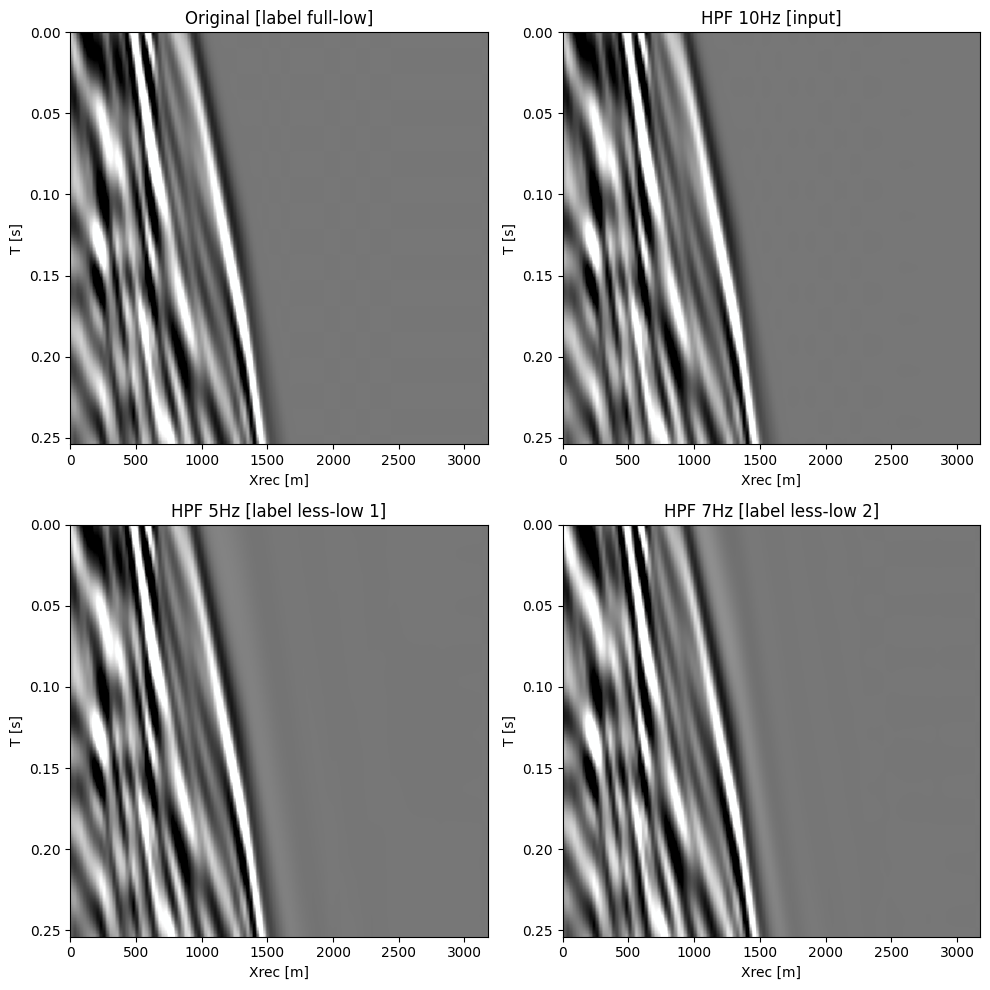

In [82]:
println(size(input_patch))
println(size(label_full))
println(size(label_less_low_1))
println(size(label_less_low_2))

num_shot = 35

figure(figsize=(10, 10))
subplot(221)
plot_sdata(label_full[num_shot], (0.002, 25);  new_fig = false, name = "Original [label full-low]")
subplot(222)
plot_sdata(raw_data_norm_patches[num_shot], (0.002, 25);  new_fig = false, name = "HPF 10Hz [input]")
subplot(223)
plot_sdata(label_less_low_1[num_shot], (0.002, 25);  new_fig = false, name = "HPF 5Hz [label less-low 1]")
subplot(224)
plot_sdata(label_less_low_2[num_shot], (0.002, 25);  new_fig = false, name = "HPF 7Hz [label less-low 2]")

tight_layout();

Check Spectrum Frequency

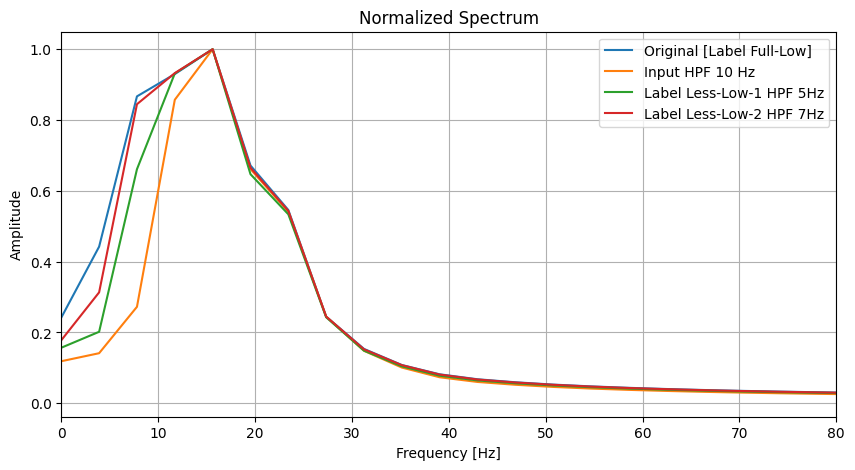

In [83]:
pos_freqs, mean_spectrum_original = extracted_mean_spectrum(label_full[num_shot], fs)
_, mean_spectrum_hpf_10_Hz = extracted_mean_spectrum(input_patch[num_shot], fs)
_, mean_spectrum_hpf_7_Hz = extracted_mean_spectrum(label_less_low_1[num_shot], fs)
_, mean_spectrum_hpf_5_Hz = extracted_mean_spectrum(label_less_low_2[num_shot], fs)

figure(figsize=(10,5))
plot(pos_freqs[1:end-1], mean_spectrum_original[1:end-1], label="Original [Label Full-Low]")
plot(pos_freqs[1:end-1], mean_spectrum_hpf_10_Hz[1:end-1], label="Input HPF 10 Hz")
plot(pos_freqs[1:end-1], mean_spectrum_hpf_5_Hz[1:end-1], label="Label Less-Low-1 HPF 5Hz")
plot(pos_freqs[1:end-1], mean_spectrum_hpf_7_Hz[1:end-1], label="Label Less-Low-2 HPF 7Hz")

legend()
grid()
xlim(0, 80)
title("Normalized Spectrum")
xlabel("Frequency [Hz]")
ylabel("Amplitude");

In [84]:
function save_to_h5(data, filename)
    # Ensure all matrices have the same size
    rows, cols = size(data[1])  # Get dimensions of the first matrix
    num_matrices = length(data)  # Number of matrices

    # Check for consistent matrix sizes
    for matrix in data
        if size(matrix) != (rows, cols)
            throw(ArgumentError("All matrices must have the same dimensions."))
        end
    end

    # Preallocate a 3D array
    combined_data = Array{Float32}(undef, rows, cols, num_matrices)

    # Fill the 3D array with the matrices
    for i in 1:num_matrices
        combined_data[:, :, i] = data[i]'
    end

    if isfile(filename)
        println("File $filename already exists. Overwriting...")
        rm(filename)  # Remove the existing file
    end

    # Save to HDF5
    h5write(filename, "dataset", combined_data)

    println("Data successfully saved to $filename")
end

save_to_h5 (generic function with 1 method)

In [85]:
dir = "../data/datasets/"
save_to_h5(input_patch, "$(dir)/inputs/input_10Hz.h5")
save_to_h5(label_full, "$(dir)/outputs/label_full.h5")
save_to_h5(label_less_low_1, "$(dir)/outputs/label_less_low_1.h5")
save_to_h5(label_less_low_2, "$(dir)/outputs/label_less_low_2.h5")
save_to_h5(raw_data_norm_patches, "$(dir)/outputs/raw_patches_norm.h5")

File ../data/datasets//inputs/input_10Hz.h5 already exists. Overwriting...
Data successfully saved to ../data/datasets//inputs/input_10Hz.h5
File ../data/datasets//outputs/label_full.h5 already exists. Overwriting...
Data successfully saved to ../data/datasets//outputs/label_full.h5
File ../data/datasets//outputs/label_less_low_1.h5 already exists. Overwriting...
Data successfully saved to ../data/datasets//outputs/label_less_low_1.h5
File ../data/datasets//outputs/label_less_low_2.h5 already exists. Overwriting...
Data successfully saved to ../data/datasets//outputs/label_less_low_2.h5
Data successfully saved to ../data/datasets//outputs/raw_patches_norm.h5
